# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Examine FRILL importances](#Examine-FRILL-importances)
* [Throw out some *surprise* samples](#Throw-out-some-surprise-samples)
* [Try fewer features](#Try-fewer-features)
* [Linear discriminant analysis of FRILL embeddings](#Linear-discriminant-analysis-of-FRILL-embeddings)
* [One-class linear discriminant analysis of FRILL embeddings](#One-class-linear-discriminant-analysis-of-FRILL-embeddings)
* [Local outlier factor of LDA components of FRILL embeddings](#Local-outlier-factor-of-LDA-components-of-FRILL-embeddings)
* [One-class SVM scores of the LDA components of the FRILL embeddings](One-class-SVM-scores-of-the-LDA-components-of-the-FRILL-embeddings)
* [SGDOneClassSVM scores of FRILL embeddings and resultant LDA components](#SGDOneClassSVM-scores-of-FRILL-embeddings-and-resultant-LDA-components)
* [Spherical coordinates](#Spherical-coordinates)
* [LDA components of spherical FRILL-based features](#LDA-components-of-spherical-FRILL-based-features)
* [One-class LDA components of spherical FRILL-based features](#One-class-LDA-components-of-spherical-FRILL-based-features)
* [Aggregate and scale](#Aggregate-and-scale)
* [Spot check](#Spot-check)
* [Discussion](#Discussion)

# Introduction

We built a prototype, but the feature extraction pipeline was bulky at about 5 GB. In this notebook, we apply several simplifications to the previous pipeline to redevelop the prototype. My hunch is that many of the intermediate features are redundant and noisy, so final performance could even improve.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [121]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from gc import collect as gc_collect
from joblib import dump
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# typing
from sklearn.base import BaseEstimator
from typing import Callable, List, Tuple

# feature engineering
from numpy import arctan2, sqrt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifierCV, SGDOneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from sklearn.svm import OneClassSVM

# visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib widget
sns.set_theme(context="notebook", style="ticks", palette="colorblind")

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

time: 6.99 ms


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 163 ms


# Data loading

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    keep_columns = [
        "id",
        "source",
        "speaker_id",
        "speaker_gender",
        "emo",
        "valence",
        "neg",
        "neu",
        "pos",
        "lang1",
        "length",
    ]
    labels = pd.concat(
        (
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
            ),
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/nondev_labels.feather", columns=keep_columns
            ),
        )
    ).set_index("id")
    return labels


def load_data(filepath: str = "") -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Loads the FRILL data anew by default"""
    data = (
        pd.read_feather(f"{filepath}.feather")
        if filepath
        else pd.concat(
            (
                pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather"),
                pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/nondev_FRILL.feather"),
            )
        )
    ).set_index("id")

    return data, load_labels().loc[data.index, :]


data, labels = load_data()
frill_columns = data.columns

assert all(data.index == labels.index)
_ = gc_collect()

time: 1.64 s


In [6]:
data.head(1)
data.info()
labels.head(1)
labels.info()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,-0.226529,-0.091773,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.06233


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 678.4 MB


,source,speaker_id,speaker_gender,emo,valence,neg,neu,pos,lang1,length
id,,,,,,,,,,
0,aesdd,aesdd.1,f,ang,0,True,False,False,ell,medium


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          86752 non-null  category
 1   speaker_id      86752 non-null  category
 2   speaker_gender  86752 non-null  category
 3   emo             86752 non-null  category
 4   valence         86752 non-null  int8    
 5   neg             86752 non-null  bool    
 6   neu             86752 non-null  bool    
 7   pos             86752 non-null  bool    
 8   lang1           86752 non-null  category
 9   length          86752 non-null  category
dtypes: bool(3), category(6), int8(1)
memory usage: 1.6 MB
time: 186 ms


# Setup

In [7]:
# valence label codes
VALENCE = {"neg": 0, "neu": 1, "pos": 2}

# ternary to binary labels per class
RECODER = {
    "neg": lambda y: ((y - 1) // 2) * (-1),
    "neu": lambda y: y % 2,
    "pos": lambda y: y // 2,
}

_ = gc_collect()

time: 118 ms


In [8]:
def plot1d(data: pd.DataFrame, labels: pd.DataFrame, x: str) -> None:
    sns.displot(
        x=data[x],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
    )
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()


_ = -gc_collect()

time: 119 ms


In [9]:
def plot2d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str) -> None:
    """Scatterplot of two variables"""
    _ = sns.histplot(
        x=data[x],
        y=data[y],
        cmap="RdPu",
        linewidth=0,
        alpha=0.2,
        legend=False,
        kde=True,
    )
    _ = sns.scatterplot(
        x=data[x],
        y=data[y],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
        s=10,
    )
    sns.despine(**dict.fromkeys("top right left bottom".split(), True))
    plt.show()


_ = gc_collect()

time: 116 ms


In [10]:
def plot3d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str, z: str) -> None:
    """Scatterplot of three variables"""
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        data[x],
        data[y],
        data[z],
        alpha=0.5,
        linewidth=0,
        cmap="viridis",
        c=labels.valence,
    )
    ax.grid(False)
    plt.show()


_ = gc_collect()

time: 98.5 ms


In [11]:
def checkpoint_features(df: pd.DataFrame, features: List[str]) -> None:
    """Save features to disk as a .feather dataframe"""
    df = df.loc[:, features]
    df.columns = df.columns.astype(str)
    try:
        df.to_feather(
            _ := f"{DATA_OUT_FOLDER}/{'_-_'.join(features) if len(features) > 1 else features[0]}.feather"
        )
    except ValueError:
        df.reset_index().to_feather(_)


_ = gc_collect()

time: 113 ms


In [12]:
def plot_importances(
    fitted_tree: BaseEstimator, fig_height: int = 100, title: str = ""
) -> None:
    """Plot top 100 feature importances"""
    data = pd.Series(
        fitted_tree.feature_importances_, index=fitted_tree.feature_names_in_
    ).sort_values(ascending=False)
    if len(data) >= 100:
        data = data.head(100)
    plt.figure(figsize=(10, fig_height))
    sns.barplot(
        x=data.values,
        y=data.index,
        seed=SEED,
        palette="colorblind",
        linewidth=0,
    )
    sns.despine(top=True, right=True)
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 96 ms


In [13]:
bagged_gnb = lambda: BaggingClassifier(
    base_estimator=GaussianNB(),
    n_estimators=25,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
)
_ = gc_collect()

time: 113 ms


# Examine FRILL importances

I hadn't occured to me to examine feature importances of the FRILL embeddings themselves until now. Although they are hard to interpret, we shouldn't assume that all 2,048 are relevant or non-redundant.

Let's quickly choose some hyperparameters. We're not being choosy; we just don't want overgrown trees and generally okay performance.

In [14]:
bagged_gnb().fit(data, labels.valence).oob_score_

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


0.511780708225747

time: 3min 43s


gini balanced


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.6226023607524899

mean importance: 0.00048828125


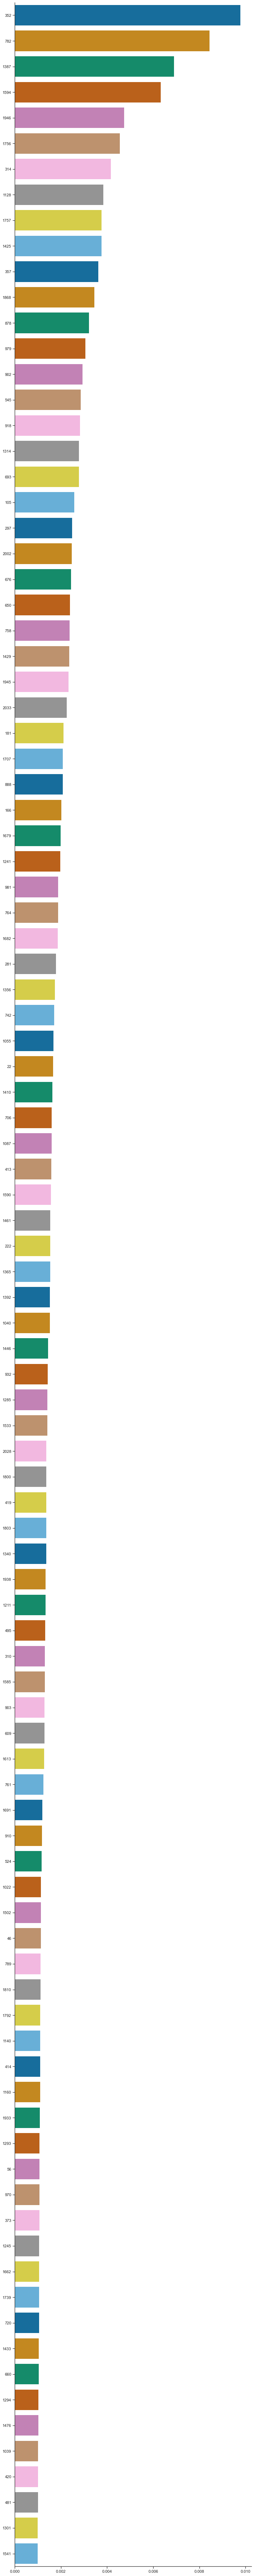

gini balanced_subsample


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.6242737919586868

mean importance: 0.00048828125


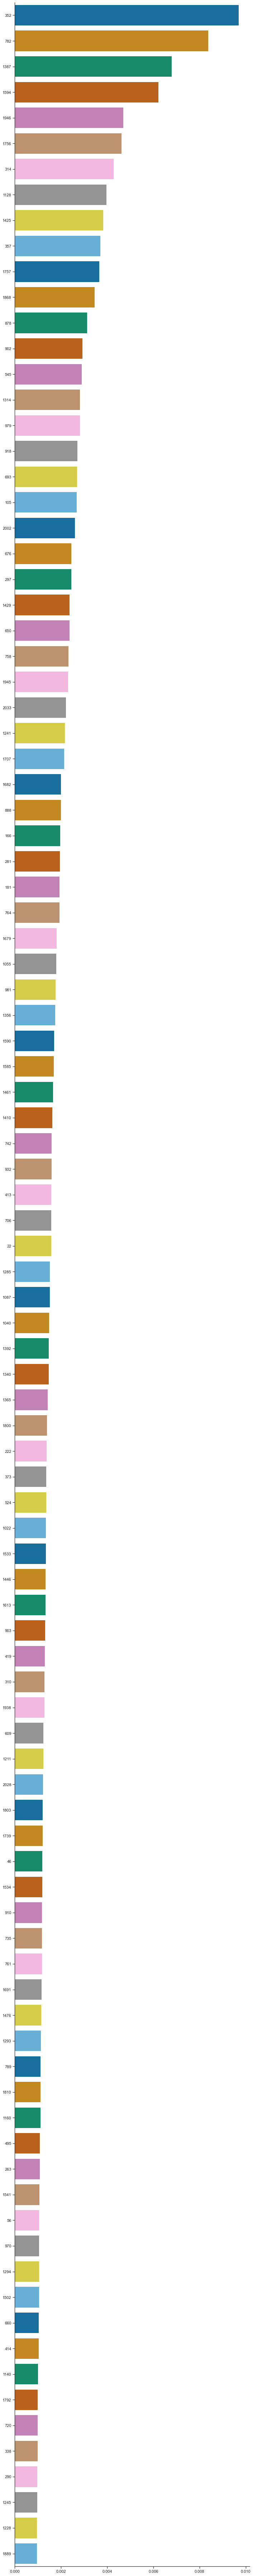

gini None


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.5980957211361121

mean importance: 0.00048828125


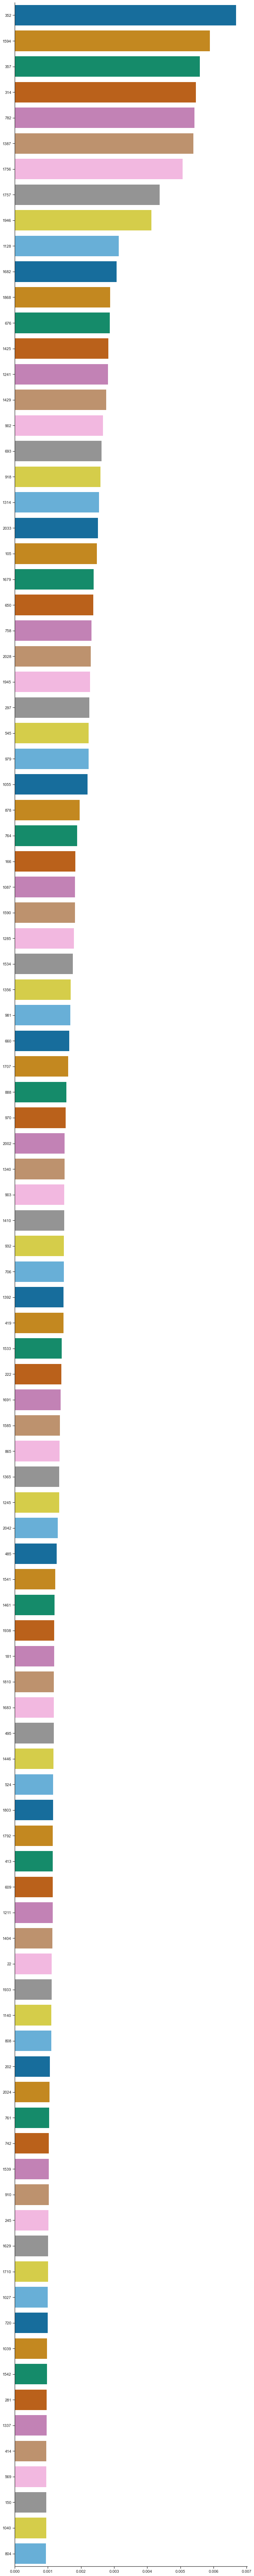

entropy balanced


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.6147869789745481

mean importance: 0.00048828125


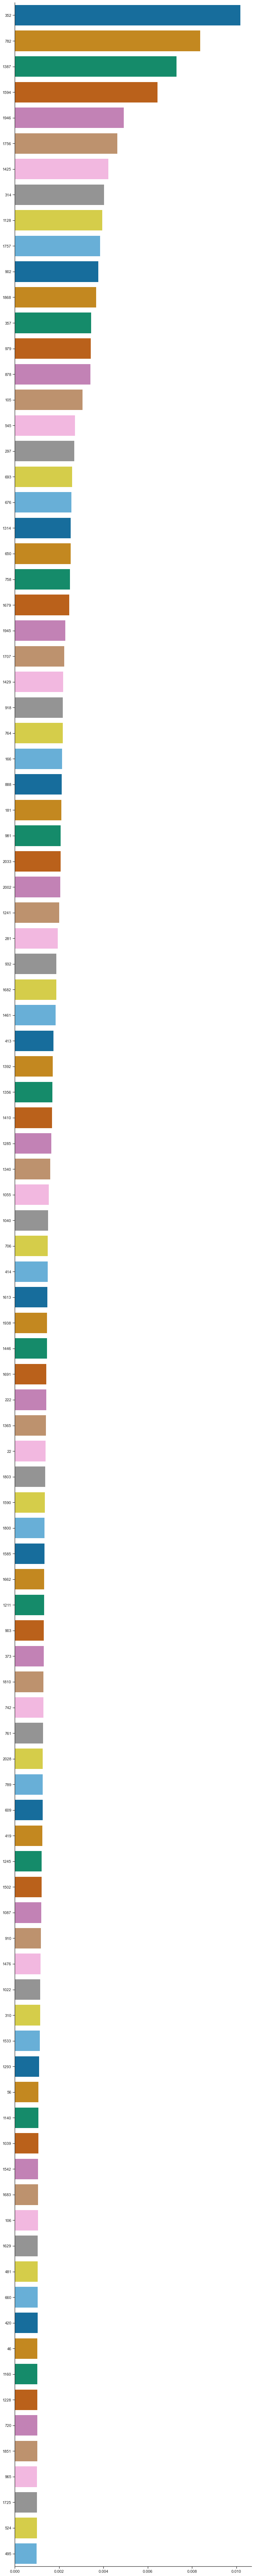

entropy balanced_subsample


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.6155823496864625

mean importance: 0.00048828125


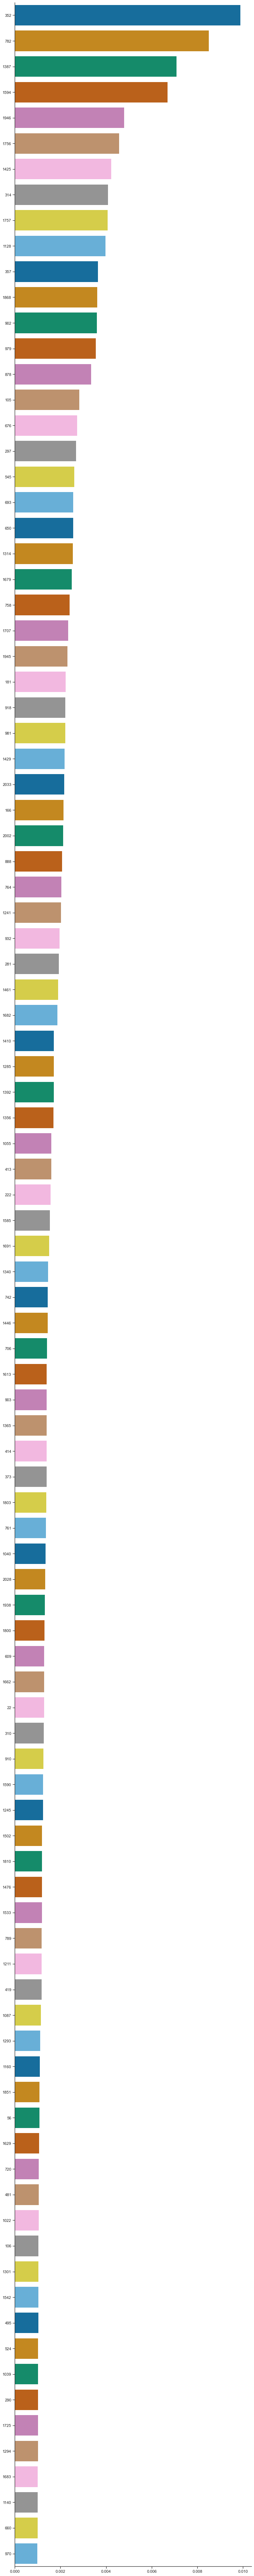

entropy None


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.597553946883069

mean importance: 0.00048828125


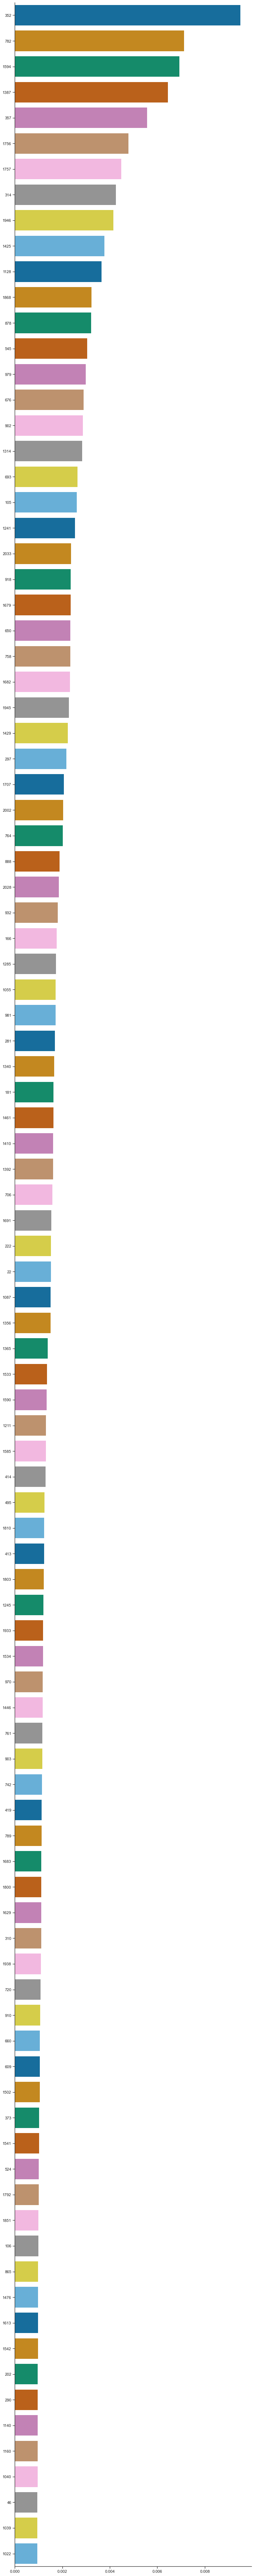

time: 20min 51s


In [15]:
for criterion in {"gini", "entropy"}:
    for class_weight in {"balanced", "balanced_subsample", None}:
        print(criterion, class_weight)
        forest = RandomForestClassifier(
            criterion=criterion,
            max_depth=15,
            min_samples_leaf=5,
            max_leaf_nodes=2000,
            bootstrap=True,
            class_weight=class_weight,
            oob_score=True,
            n_jobs=-1,
            random_state=SEED,
        ).fit(data, labels.valence)
        forest.oob_score_
        print(f"mean importance:", np.mean(forest.feature_importances_))
        plot_importances(forest)

We don't need all of these probably.

# Throw out some *surprise* samples

In [16]:
# MAV surprise stays negative
# TESS is pleasant surprise
# keep EmoReact surprise valences
# keep MELD surprise valences
# keep vivae pleasant surprise
keep_surprise = {"EmoReact_V_1.0", "MAV", "MELD", "tess", "vivae"}
discard_index = (
    data.loc[~labels.source.isin(keep_surprise)].loc[labels.emo == "sur"].index
)
data2 = data.loc[~data.index.isin(discard_index)]
labels2 = labels.loc[data2.index]

time: 813 ms


Are the importances the same after we threw out some *surprise* samples?

In [17]:
bagged_gnb().fit(data2, labels2.valence).oob_score_

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


0.5196186704241086

time: 3min


Improved!

gini balanced


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.6066110666818996

mean importance: 0.00048828125


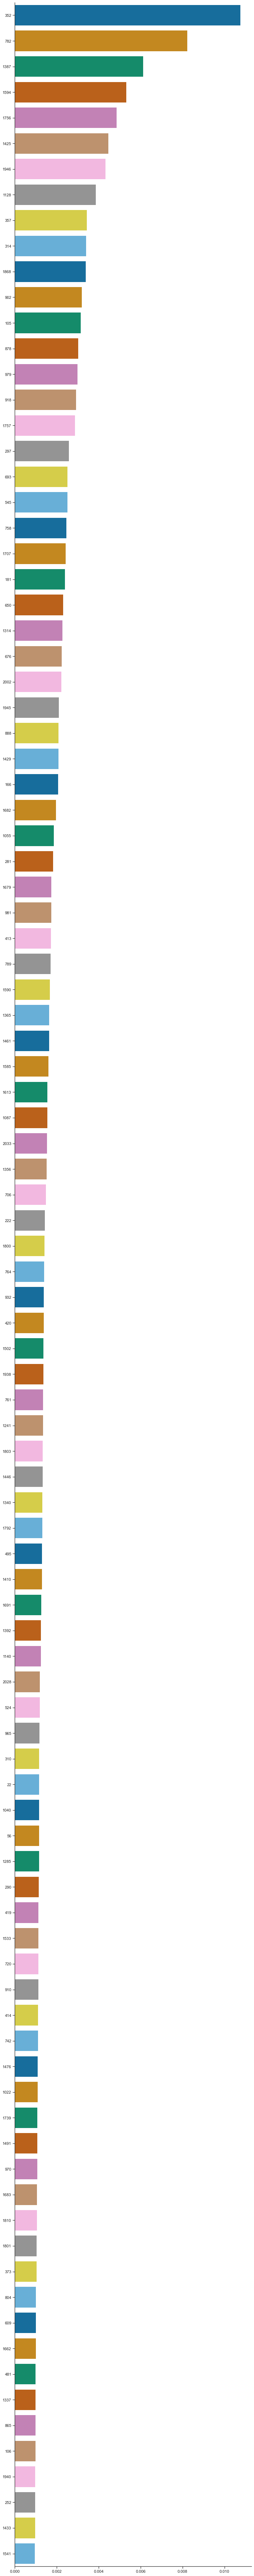

gini balanced_subsample


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.6040595605316272

mean importance: 0.0004882812500000001


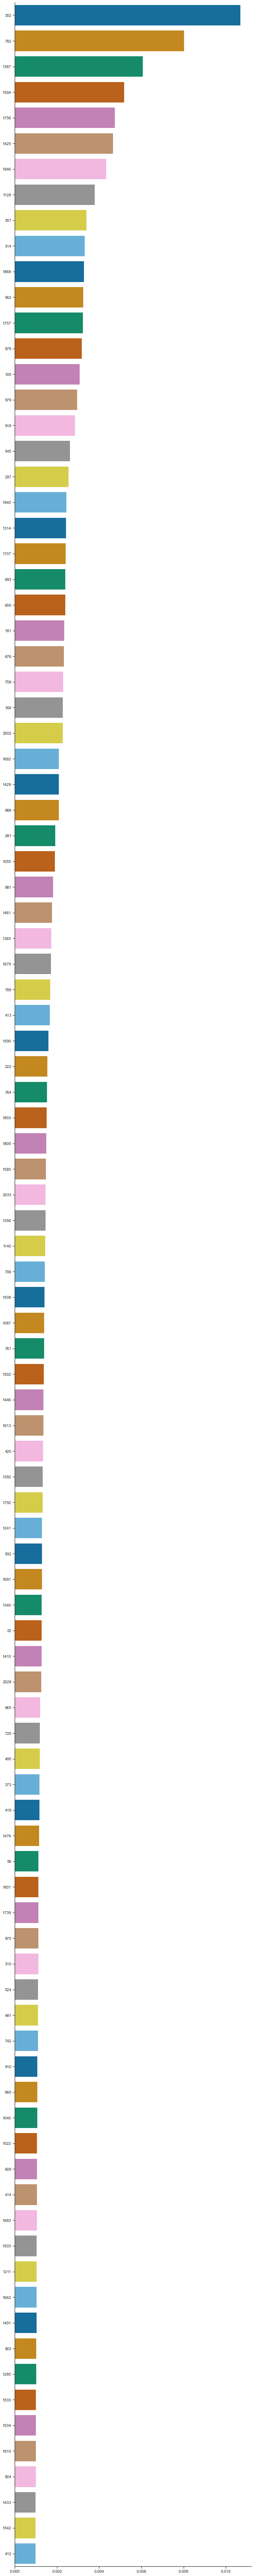

gini None


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.5802708912499841

mean importance: 0.00048828125


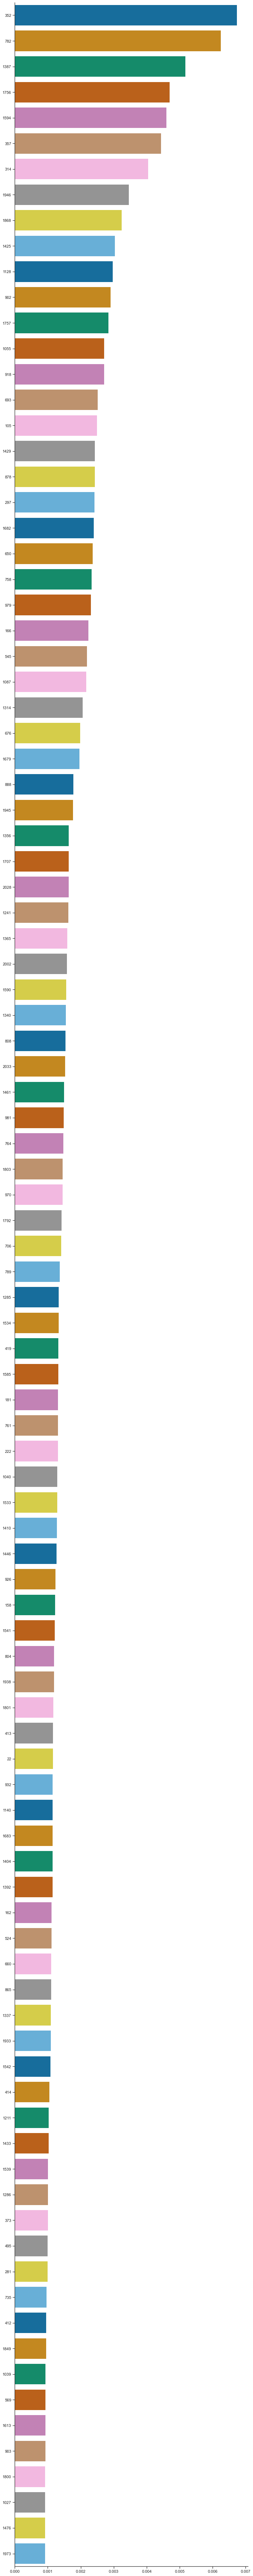

entropy balanced


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.605011615065311

mean importance: 0.00048828125


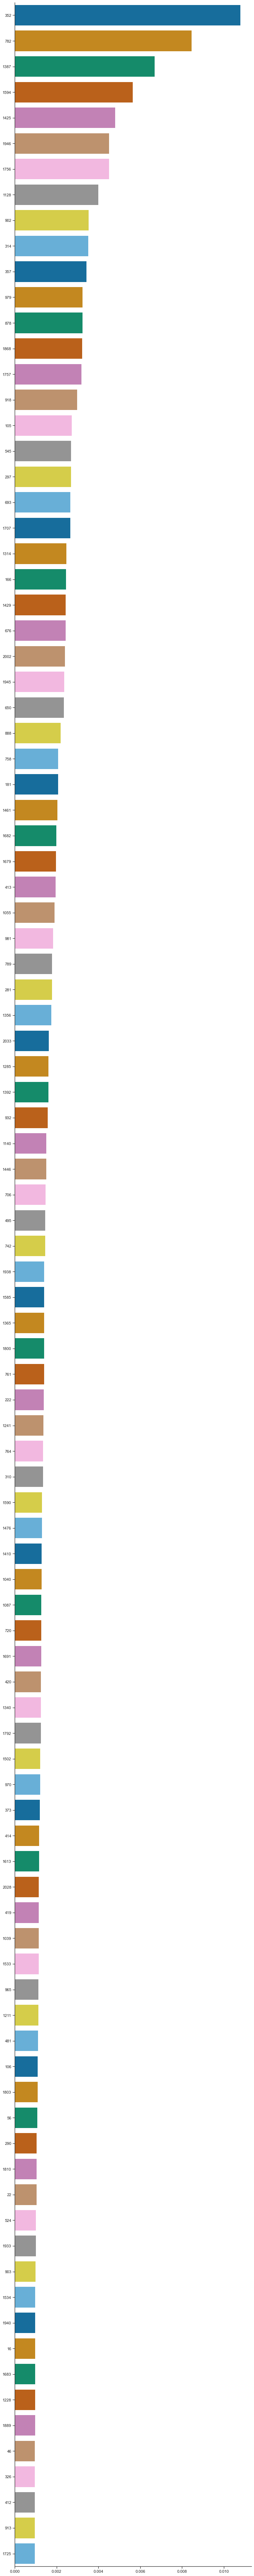

entropy balanced_subsample


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.6027012960635718

mean importance: 0.00048828125


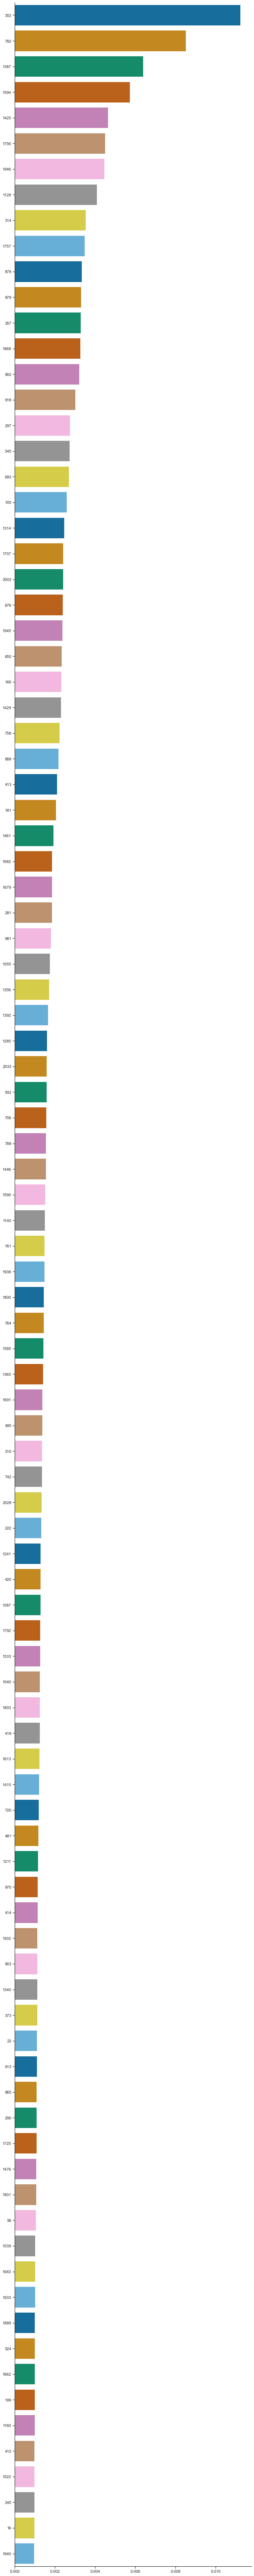

entropy None


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.5801693387663912

mean importance: 0.00048828125


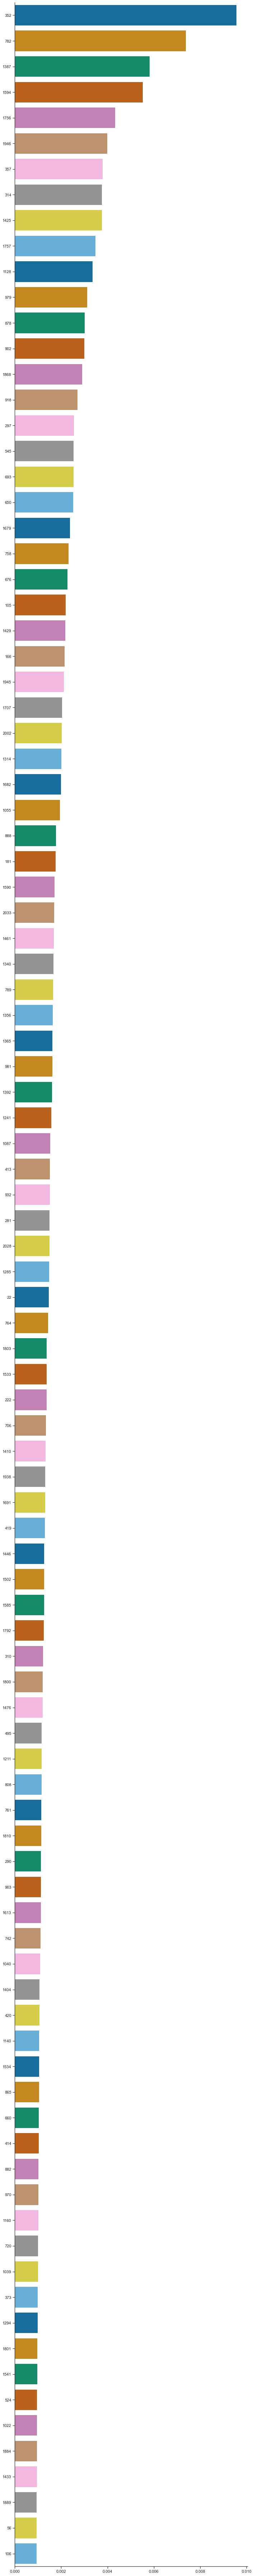

time: 19min 19s


In [18]:
for criterion in {"gini", "entropy"}:
    for class_weight in {"balanced", "balanced_subsample", None}:
        print(criterion, class_weight)
        forest = RandomForestClassifier(
            criterion=criterion,
            max_depth=15,
            min_samples_leaf=5,
            max_leaf_nodes=2000,
            bootstrap=True,
            class_weight=class_weight,
            oob_score=True,
            n_jobs=-1,
            random_state=SEED,
        ).fit(data2, labels2.valence)
        forest.oob_score_
        print(f"mean importance:", np.mean(forest.feature_importances_))
        plot_importances(forest)

# Try fewer features

In [19]:
data, labels = deepcopy(data2), deepcopy(labels2)
estimator = RandomForestClassifier(
    criterion="gini",
    max_depth=15,
    class_weight="balanced",
    min_samples_leaf=5,
    max_leaf_nodes=2000,
    bootstrap=True,
    n_jobs=-1,
    random_state=SEED + 1,
).fit(data, labels.valence)
selector = SelectFromModel(estimator=estimator, threshold="median", prefit=True)
selected_data = pd.DataFrame(
    selector.transform(data), columns=selector.get_feature_names_out(data.columns)
)
print(f"there are now {len(selected_data.columns)} columns")

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


there are now 1024 columns
time: 25 s


In [20]:
bagged_gnb().fit(selected_data, labels.valence).oob_score_

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


0.5247724589664496

time: 1min 1s


Improved!

In [21]:
data3 = data.loc[:, selector.get_feature_names_out(data.columns)]
assert all(data3.columns == selected_data.columns)
labels3 = labels2
print(len(data3.columns))
assert all(data3.index == labels3.index)

1024
time: 218 ms


In [22]:
dump(selector, f"{DATA_OUT_FOLDER}/frill_column_selector.joblib")
_ = gc_collect()

['./frill_column_selector.joblib']

time: 939 ms


In [23]:
del data
del data2
del labels
del labels2
_ = gc_collect()

time: 177 ms


# Linear discriminant analysis of FRILL embeddings

In [24]:
data = deepcopy(data3)
labels = deepcopy(labels3)
assert all(data.index == labels.index)

time: 82 ms


['./LDA1_-_LDA2.joblib']

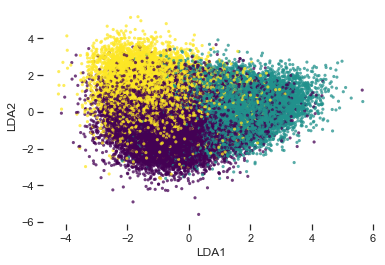

time: 20.7 s


In [25]:
lda = LinearDiscriminantAnalysis().fit(data, labels.valence)
dump(lda, f"{DATA_OUT_FOLDER}/LDA1_-_LDA2.joblib")
features = ["LDA1", "LDA2"]
data = pd.DataFrame(lda.transform(data), columns=features)
data.index = labels.index
del lda
_ = gc_collect()
assert not data.isnull().values.any()
plot2d(data, labels, *features)
checkpoint_features(data, features)  # LDA1_-_LDA2.feather

In [26]:
bagged_gnb().fit(data, labels.valence).oob_score_

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


0.67437196135928

time: 627 ms


Improved!

# One-class linear discriminant analysis of FRILL embeddings

In [27]:
data = deepcopy(data3)
labels = deepcopy(labels3)
frill_columns = data3.columns

time: 102 ms


['./ocLDA_neg.joblib']

['./ocLDA_neu.joblib']

['./ocLDA_pos.joblib']

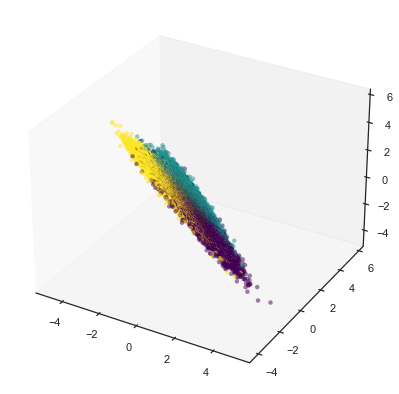

time: 1min


In [28]:
for valence in VALENCE.keys():
    feature = f"ocLDA_{valence}"
    lda = LinearDiscriminantAnalysis().fit(
        data.loc[:, frill_columns], RECODER[valence](labels.valence)
    )
    data[feature] = np.squeeze(lda.transform(data.loc[:, frill_columns]))
    dump(lda, f"{DATA_OUT_FOLDER}/{feature}.joblib")
    del feature
    del lda
    _ = gc_collect()
features = ["ocLDA_neg", "ocLDA_neu", "ocLDA_pos"]
checkpoint_features(data, features)
plot3d(data, labels, *features)

assert not data.isnull().values.any()
_ = gc_collect()

# Local outlier factor of LDA components of FRILL embeddings

In [29]:
data, labels = load_data(filepath=f"{DATA_OUT_FOLDER}/LDA1_-_LDA2")
assert len(data) == len(labels)

time: 77.2 ms


['./LDA-LOF_neg_30.joblib']

['./LDA-LOF_neu_30.joblib']

['./LDA-LOF_pos_30.joblib']

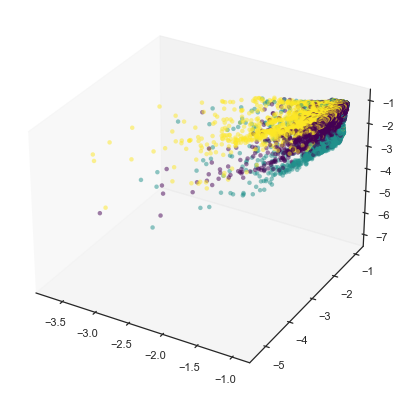

time: 2.8 s


In [30]:
n_neighbors = 30
for emo in ("neg", "neu", "pos"):
    valence = VALENCE[emo]
    key = f"LDA-LOF_{emo}_{n_neighbors}"
    data[key] = np.nan
    lof = LocalOutlierFactor(n_neighbors, novelty=True, n_jobs=-1).fit(
        data.loc[labels.valence == valence, ["LDA1", "LDA2"]].values
    )
    data.loc[labels.valence == valence, key] = lof.negative_outlier_factor_
    data.loc[labels.valence != valence, key] = lof.score_samples(
        data.loc[labels.valence != valence, ["LDA1", "LDA2"]].values
    )
    dump(lof, f"{DATA_OUT_FOLDER}/{key}.joblib")
    del valence
    del key
    del lof
    _ = gc_collect()
features = [
    f"LDA-LOF_neg_{n_neighbors}",
    f"LDA-LOF_neu_{n_neighbors}",
    f"LDA-LOF_pos_{n_neighbors}",
]
plot3d(data, labels, *features)
checkpoint_features(data, features)
del features
_ = gc_collect()

# One-class SVM scores of the LDA components of the FRILL embeddings

In [31]:
def extract_ocsvm_features(
    df: pd.DataFrame, labels: pd.DataFrame, model_base: Callable, descriptor: str
) -> pd.DataFrame:
    """Extract features using the given one-class SVM base"""
    prefix = f"ocSVM_{descriptor}"
    assert all(df.index == labels.index)

    # one-class scores of LDA components of FRILL embeddings
    print("extracting one-class scores of LDA components of FRILL embeddings...")
    for valence in VALENCE.keys():
        classifier = model_base().fit(
            df.loc[labels.valence == VALENCE[valence], ["LDA1", "LDA2"]]
        )
        feature = f"LDA-{prefix}_{valence}"
        df[feature] = classifier.score_samples(df.loc[:, ["LDA1", "LDA2"]])
        dump(classifier, f"{DATA_OUT_FOLDER}/{feature}.joblib")
        del classifier
        del feature
        _ = gc_collect()
    assert all(df.index == labels.index)
    features = [f"LDA-{prefix}_neg", f"LDA-{prefix}_neu", f"LDA-{prefix}_pos"]
    plot3d(df, labels, *features)
    checkpoint_features(df, features)

    return df


_ = gc_collect()

time: 99 ms


In [32]:
data, labels = load_data(filepath=f"{DATA_OUT_FOLDER}/LDA1_-_LDA2")
assert len(data) == len(labels)
assert all(data.index == labels.index)

time: 36.4 ms


In [33]:
oc_svms = {
    "sgdlinear": lambda: SGDOneClassSVM(random_state=SEED),
    "rbf": lambda: OneClassSVM(kernel="rbf"),
    "sigmoid": lambda: OneClassSVM(kernel="sigmoid"),
    "poly5": lambda: OneClassSVM(kernel="poly", degree=5),
    "poly6": lambda: OneClassSVM(kernel="poly", degree=6),
}
_ = gc_collect()

time: 141 ms


  0%|          | 0/5 [00:00<?, ?it/s]

extracting one-class scores of LDA components of FRILL embeddings...


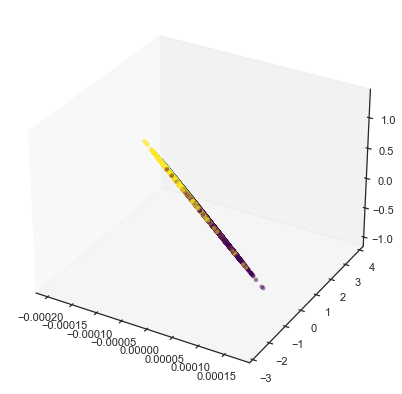

extracting one-class scores of LDA components of FRILL embeddings...


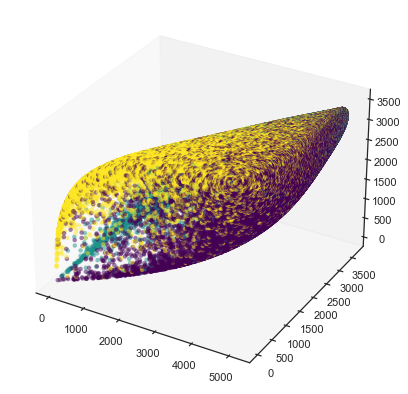

extracting one-class scores of LDA components of FRILL embeddings...


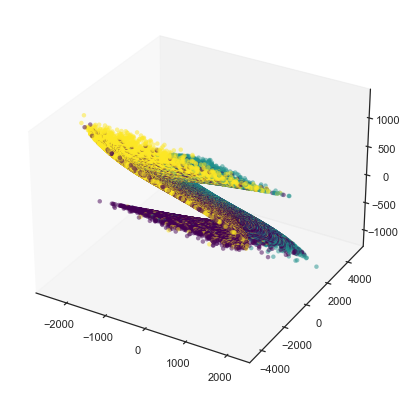

extracting one-class scores of LDA components of FRILL embeddings...


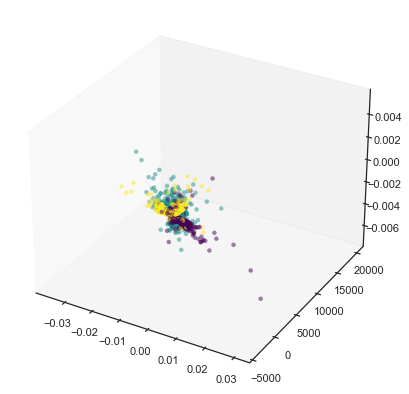

extracting one-class scores of LDA components of FRILL embeddings...


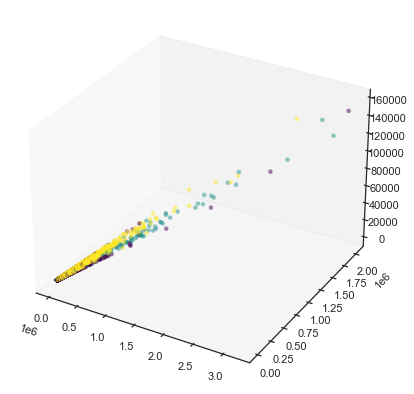

time: 12h 14min 13s


In [34]:
for oc_svm, model_base in tqdm(oc_svms.items()):
    data = extract_ocsvm_features(data, labels, model_base, oc_svm)

# SGDOneClassSVM scores of FRILL embeddings and resultant LDA components

In [74]:
data, labels = load_data()
data = data.loc[:, frill_columns]
labels = labels.loc[data.index]
assert len(data.columns) == 1024
assert all(data.index == labels.index)

time: 1.76 s


In [75]:
# retrieve -surprise index
df, labels = load_data("LDA1_-_LDA2")
data = data.loc[df.index, :]

time: 339 ms


['./ocSVM_sgdlinear_neg.joblib']

['./ocSVM_sgdlinear_neu.joblib']

['./ocSVM_sgdlinear_pos.joblib']

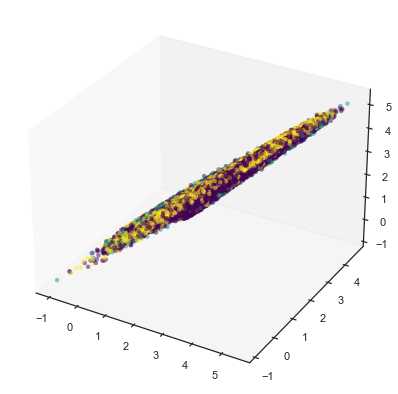

time: 5.01 s


In [76]:
prefix = f"ocSVM_sgdlinear"
for valence in VALENCE.keys():
    classifier = SGDOneClassSVM(random_state=SEED).fit(
        data.loc[labels.valence == VALENCE[valence], frill_columns]
    )
    feature = f"{prefix}_{valence}"
    data[feature] = classifier.score_samples(data.loc[:, frill_columns])
    dump(classifier, f"{DATA_OUT_FOLDER}/{feature}.joblib")
    del classifier
    _ = gc_collect()
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]
plot3d(data, labels, *features)
checkpoint_features(data, features)

In [77]:
prefix = "ocSVM_sgdlinear"
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]

time: 997 µs


['./ocSVM_sgdlinear_LDA1_-_ocSVM_sgdlinear_LDA2.joblib']

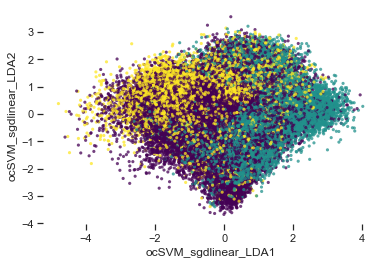

time: 1.12 s


In [78]:
lda = LinearDiscriminantAnalysis().fit(data.loc[:, features], labels.valence)
dump(lda, f"{DATA_OUT_FOLDER}/ocSVM_sgdlinear_LDA1_-_ocSVM_sgdlinear_LDA2.joblib")
features_ = ["ocSVM_sgdlinear_LDA1", "ocSVM_sgdlinear_LDA2"]
data = pd.DataFrame(lda.transform(data.loc[:, features]), columns=features_)
data.index = labels.index
del lda
_ = gc_collect()
assert not data.isnull().values.any()
plot2d(data, labels, *features_)
checkpoint_features(data, features_)

# Spherical coordinates

NB: We are dropping the rho coordinates

In [110]:
features_ = [
    ["LDA1", "LDA2"],
    ["ocLDA_neg", "ocLDA_neu", "ocLDA_pos"],
    ["ocSVM_sgdlinear_LDA1", "ocSVM_sgdlinear_LDA2"],
    ["ocSVM_sgdlinear_neg", "ocSVM_sgdlinear_neu", "ocSVM_sgdlinear_pos"],
    ["LDA-LOF_neg_30", "LDA-LOF_neu_30", "LDA-LOF_pos_30"],
]

for descriptor in oc_svms.keys():
    features_.extend(
        [
            [
                f"LDA-ocSVM_{descriptor}_neg",
                f"LDA-ocSVM_{descriptor}_neu",
                f"LDA-ocSVM_{descriptor}_pos",
            ],
        ]
    )

_ = gc_collect()

time: 121 ms


78777 ['LDA1', 'LDA2']


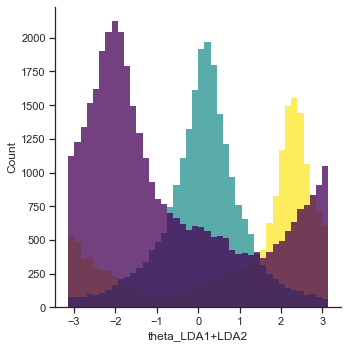

78777 ['ocLDA_neg', 'ocLDA_neu', 'ocLDA_pos']


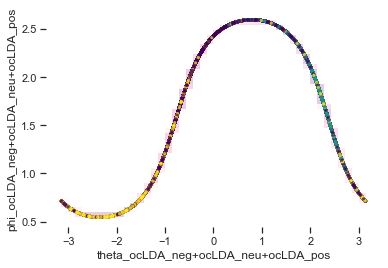

78777 ['ocSVM_sgdlinear_LDA1', 'ocSVM_sgdlinear_LDA2']


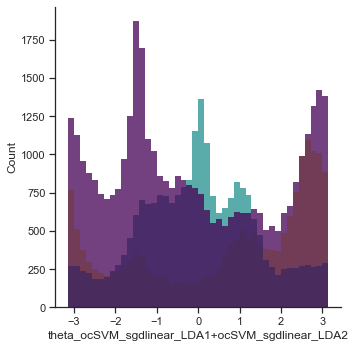

78777 ['ocSVM_sgdlinear_neg', 'ocSVM_sgdlinear_neu', 'ocSVM_sgdlinear_pos']


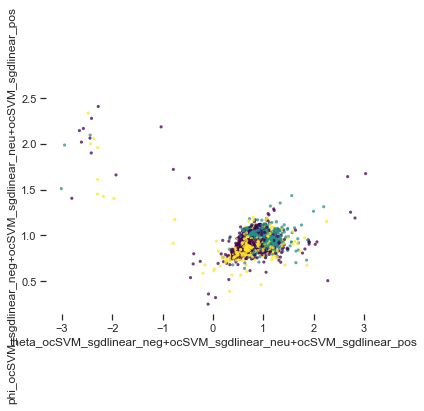

78777 ['LDA-LOF_neg_30', 'LDA-LOF_neu_30', 'LDA-LOF_pos_30']


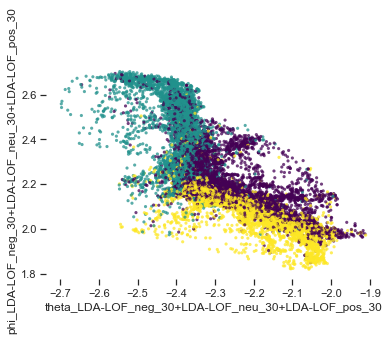

78777 ['LDA-ocSVM_sgdlinear_neg', 'LDA-ocSVM_sgdlinear_neu', 'LDA-ocSVM_sgdlinear_pos']


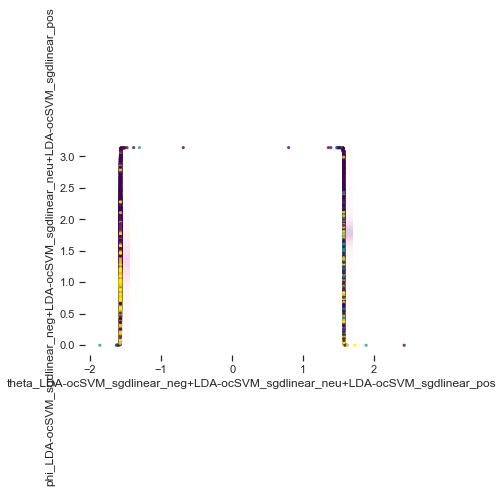

78777 ['LDA-ocSVM_rbf_neg', 'LDA-ocSVM_rbf_neu', 'LDA-ocSVM_rbf_pos']


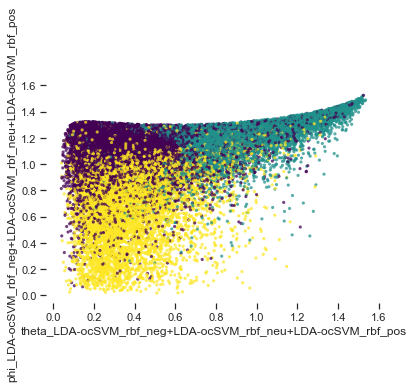

78777 ['LDA-ocSVM_sigmoid_neg', 'LDA-ocSVM_sigmoid_neu', 'LDA-ocSVM_sigmoid_pos']


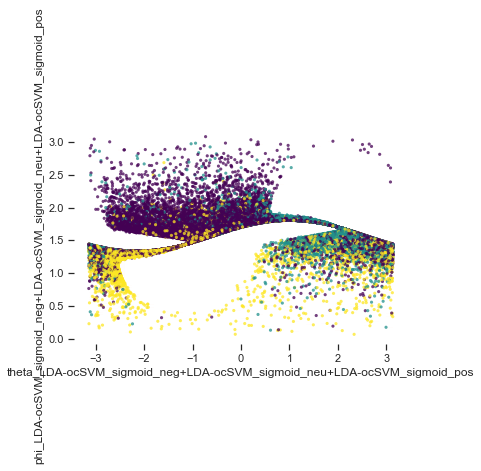

78777 ['LDA-ocSVM_poly5_neg', 'LDA-ocSVM_poly5_neu', 'LDA-ocSVM_poly5_pos']


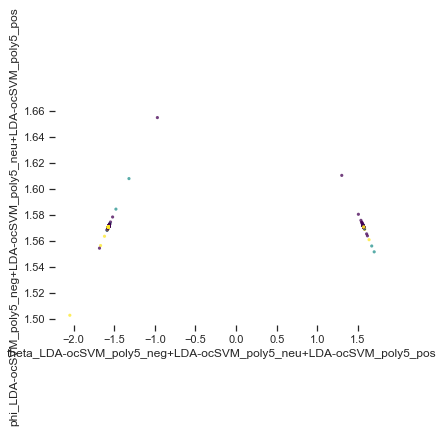

78777 ['LDA-ocSVM_poly6_neg', 'LDA-ocSVM_poly6_neu', 'LDA-ocSVM_poly6_pos']


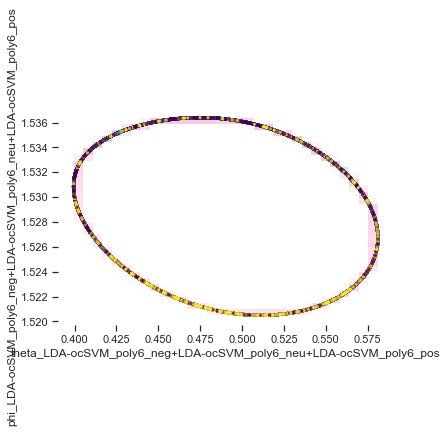

time: 34.2 s


In [111]:
# rho coordinate omitted
sphericals = {}
for features in features_:
    combo = "+".join(features)
    df = pd.read_feather(f"{DATA_OUT_FOLDER}/{'_-_'.join(features)}.feather").set_index(
        "id"
    )
    labels = load_labels().loc[df.index]
    print(len(labels), features)
    assert not df.isnull().values.any()
    assert all(df.index == labels.index)
    x, y = df[features[0]], df[features[1]]
    theta, phi = f"theta_{combo}", f"phi_{combo}"
    sphericals[theta] = arctan2(y, x)
    # convert to polar
    if len(features) == 3:
        sphericals[phi] = arctan2(sqrt(x ** 2 + y ** 2), df[features[2]])
        plot2d(
            df := pd.DataFrame({theta: sphericals[theta], phi: sphericals[phi]}),
            labels,
            theta,
            phi,
        )
        assert not df.isnull().values.any()
    else:
        plot1d(df := pd.DataFrame({theta: sphericals[theta]}), labels, theta)
        assert not df.isnull().values.any()
    del df
    del x
    del y
    del combo
    _ = gc_collect()

df = pd.DataFrame(sphericals)
df.columns = df.columns.astype(str)
assert not df.isnull().values.any()
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/spherical_features.feather")
del sphericals
_ = gc_collect()

# LDA components of spherical FRILL-based features

In [112]:
data, labels = load_data(filepath=f"{DATA_OUT_FOLDER}/spherical_features")
assert all(data.index == labels.index)
assert not data.isnull().values.any()

time: 67.1 ms


['./spherical-LDA1_-_spherical-LDA2.joblib']

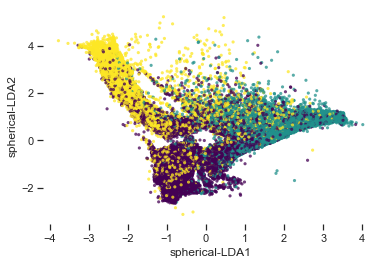

time: 1.3 s


In [113]:
new_feats = []
lda = LinearDiscriminantAnalysis().fit(data, labels.valence)
dump(lda, f"{DATA_OUT_FOLDER}/spherical-LDA1_-_spherical-LDA2.joblib")
features = ["spherical-LDA1", "spherical-LDA2"]
df = pd.DataFrame(lda.transform(data), columns=features)
df.index = data.index
del data
del lda
_ = gc_collect()
plot2d(df, labels, *features)
checkpoint_features(df, features)
new_feats.append(features)

# One-class LDA components of spherical FRILL-based features

In [114]:
data, labels = load_data(filepath=f"{DATA_OUT_FOLDER}/spherical_features")

time: 63.4 ms


['./spherical-ocLDA_neg.joblib']

['./spherical-ocLDA_neu.joblib']

['./spherical-ocLDA_pos.joblib']

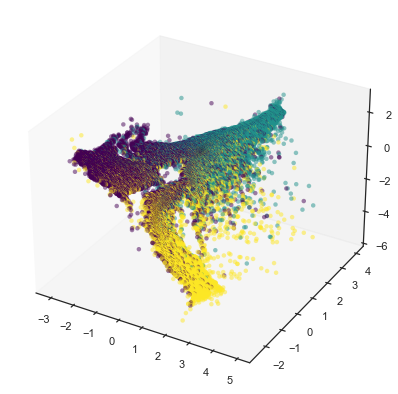

time: 2.04 s


In [115]:
df = {}
features = []
for valence in VALENCE:
    features.append(feature := f"spherical-ocLDA_{valence}")
    lda = LinearDiscriminantAnalysis().fit(data, RECODER[valence](labels.valence))
    dump(lda, f"{DATA_OUT_FOLDER}/{feature}.joblib")
    df[feature] = np.squeeze(lda.transform(data))
    del feature
    del lda
    _ = gc_collect()
df = pd.DataFrame(df, columns=features)
df.index = data.index
plot3d(df, labels, *features)
checkpoint_features(df, features)
del df
new_feats.append(features)
_ = gc_collect()

# Aggregate and scale

In [116]:
features_.extend(new_feats)
features_
_ = gc_collect()

[['LDA1', 'LDA2'],
 ['ocLDA_neg', 'ocLDA_neu', 'ocLDA_pos'],
 ['ocSVM_sgdlinear_LDA1', 'ocSVM_sgdlinear_LDA2'],
 ['ocSVM_sgdlinear_neg', 'ocSVM_sgdlinear_neu', 'ocSVM_sgdlinear_pos'],
 ['LDA-LOF_neg_30', 'LDA-LOF_neu_30', 'LDA-LOF_pos_30'],
 ['LDA-ocSVM_sgdlinear_neg',
  'LDA-ocSVM_sgdlinear_neu',
  'LDA-ocSVM_sgdlinear_pos'],
 ['LDA-ocSVM_rbf_neg', 'LDA-ocSVM_rbf_neu', 'LDA-ocSVM_rbf_pos'],
 ['LDA-ocSVM_sigmoid_neg', 'LDA-ocSVM_sigmoid_neu', 'LDA-ocSVM_sigmoid_pos'],
 ['LDA-ocSVM_poly5_neg', 'LDA-ocSVM_poly5_neu', 'LDA-ocSVM_poly5_pos'],
 ['LDA-ocSVM_poly6_neg', 'LDA-ocSVM_poly6_neu', 'LDA-ocSVM_poly6_pos'],
 ['spherical-LDA1', 'spherical-LDA2'],
 ['spherical-ocLDA_neg', 'spherical-ocLDA_neu', 'spherical-ocLDA_pos']]

time: 122 ms


In [136]:
data = pd.concat(
    [
        pd.read_feather(f"{DATA_OUT_FOLDER}/{fname}.feather").set_index("id")
        for fname in ["_-_".join(features) for features in features_]
    ],
    axis="columns",
)
labels = load_labels().loc[data.index]
assert not data.isnull().values.any()
assert len(data) < 80000

time: 968 ms


In [137]:
data = pd.concat(
    [
        data,
        pd.read_feather(f"{DATA_OUT_FOLDER}/spherical_features.feather").set_index(
            "id"
        ),
    ],
    axis="columns",
)

time: 294 ms


In [138]:
bagged_gnb().fit(data, labels.valence).oob_score_

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


0.6605481295301928

time: 5.97 s


In [139]:
bagged_gnb().fit(RobustScaler().fit_transform(data), labels.valence).oob_score_

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


0.6644579001485205

time: 3.62 s


In [140]:
bagged_gnb().fit(
    RobustScaler(unit_variance=True).fit_transform(data), labels.valence
).oob_score_

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


0.6644579001485205

time: 3.62 s


In [141]:
BaggingClassifier(
    base_estimator=RidgeClassifierCV(scoring="balanced_accuracy"),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
).fit(RobustScaler().fit_transform(data), labels.valence).oob_score_

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   13.2s remaining:   39.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.4s finished


0.6784594488238953

time: 17.9 s


In [142]:
BaggingClassifier(
    base_estimator=RidgeClassifierCV(scoring="balanced_accuracy"),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
).fit(RobustScaler(unit_variance=True).fit_transform(data), labels.valence).oob_score_

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   13.5s remaining:   40.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.7s finished


0.6784975310052427

time: 18.2 s


In [143]:
dump(
    RobustScaler(unit_variance=True).fit(data),
    f"{DATA_OUT_FOLDER}/robust_scaler.joblib",
)

['./robust_scaler.joblib']

time: 138 ms


In [144]:
cols = data.columns
data = pd.DataFrame(RobustScaler().fit_transform(data), columns=cols)
data.columns = data.columns.astype(str)
assert len(labels.index) < 79000
data.index = labels.index
data.reset_index().to_feather(
    f"{DATA_OUT_FOLDER}/scaled_features_ready_for_selection.feather"
)
del cols
_ = gc_collect()

time: 859 ms


# Spot check

In [145]:
data = pd.read_feather(
    f"{DATA_OUT_FOLDER}/scaled_features_ready_for_selection.feather"
).set_index("id")
labels = load_labels().loc[data.index]
assert len(data) == len(labels)
assert all(data.index == labels.index)

time: 768 ms


In [146]:
bagged_gnb().fit(data, labels.valence).oob_score_

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


0.6644579001485205

time: 3.52 s


In [147]:
selected_features = {
    "three_sphericals": [
        "spherical-ocLDA_neg",
        "spherical-ocLDA_neu",
        "spherical-ocLDA_pos",
    ],
    "two_sphericals": ["spherical-LDA1", "spherical-LDA2"],
}
selected_features["five_sphericals"] = (
    selected_features["three_sphericals"] + selected_features["two_sphericals"]
)
for feature_set, features in selected_features.items():
    df = data.loc[:, features]
    print(feature_set, bagged_gnb().fit(df, labels.valence).oob_score_)

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


three_sphericals 0.6601926958376175


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


two_sphericals 0.6669840181778945
five_sphericals 0.6544803686355154
time: 1.75 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


In [148]:
assert len(data) < 79000
df.index
labels = load_labels().loc[df.index, :]
labels.index
labels.columns = labels.columns.astype(str)
labels.info()
labels.reset_index().to_feather(f"{DATA_OUT_FOLDER}/simplified_labels.feather")

UInt64Index([    0,     2,     4,     6,     8,    10,    12,    14,    16,
                18,
             ...
             87354, 87355, 87356, 87357, 87358, 87359, 87360, 87361, 87362,
             87363],
            dtype='uint64', name='id', length=78777)

UInt64Index([    0,     2,     4,     6,     8,    10,    12,    14,    16,
                18,
             ...
             87354, 87355, 87356, 87357, 87358, 87359, 87360, 87361, 87362,
             87363],
            dtype='uint64', name='id', length=78777)

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 78777 entries, 0 to 87363
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          78777 non-null  category
 1   speaker_id      78777 non-null  category
 2   speaker_gender  78777 non-null  category
 3   emo             78777 non-null  category
 4   valence         78777 non-null  int8    
 5   neg             78777 non-null  bool    
 6   neu             78777 non-null  bool    
 7   pos             78777 non-null  bool    
 8   lang1           78777 non-null  category
 9   length          78777 non-null  category
dtypes: bool(3), category(6), int8(1)
memory usage: 1.5 MB
time: 72.9 ms


# Discussion

Looks like the simplified feature set isn't so bad.

In [149]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 66258.99188804626 s
time: 126 ms


[^top](#Contents)